# Pneumonia detection using Convolutional Neural Network
## Dataset
The dataset comprises 5,863 JPEG X-Ray images and is categorised into two types (Pneumonia and Normal), organised into three folders: train, test, and val. Each folder contains subfolders for each image type. 

These chest X-ray images (anterior-posterior view) were sourced from paediatric patients aged one to five years at a renowned hospital. The X-rays were part of the routine clinical care of these patients.

### Setup

In [14]:
import numpy as np
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt

print(tf.__version__)


2.15.0


### Dataset loading and preprocessing

In [15]:
training_dir = './dataset/train/'
validation_dir = './dataset/val/'
test_dir = './dataset/test/'


batch_size = 32
img_height = 180
img_width = 180 

train_ds = tf.keras.utils.image_dataset_from_directory(
    training_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory( 
    test_dir, 
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [16]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


### Visualizing data

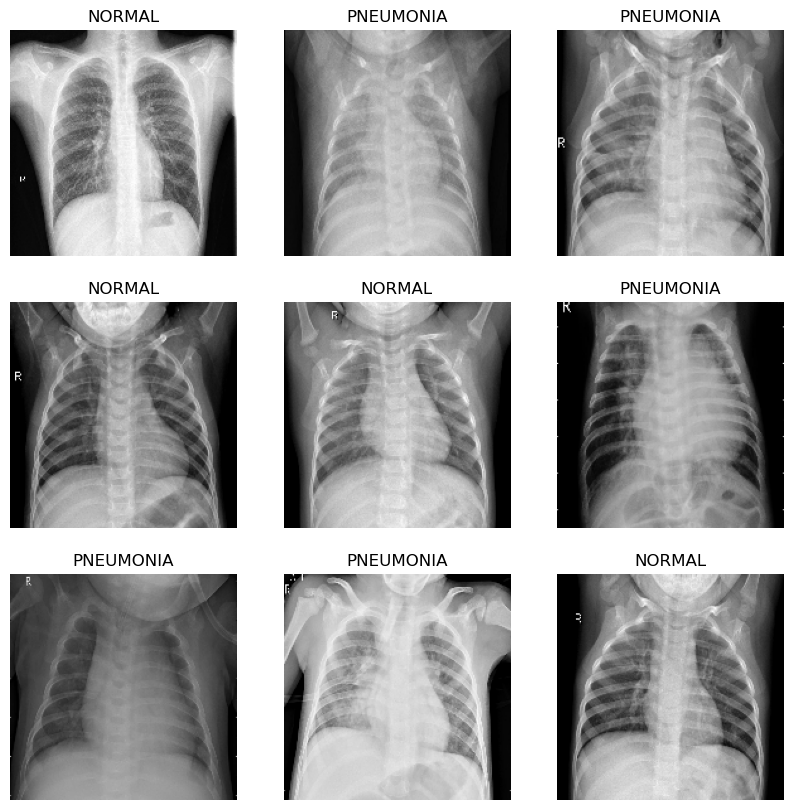

In [17]:
plt.figure(figsize=(10, 10))  
for images, labels in train_ds.take(1):  
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)  
    plt.imshow(images[i].numpy().astype("uint8"))  
    plt.title(class_names[labels[i]])  
    plt.axis("off") 



In [18]:
for image_batch, labels_batch in train_ds:
    print(f'The size of one image batch: {image_batch.shape}')
    print(f'The size of labels batch: {labels_batch.shape}')
    break

The size of one image batch: (32, 180, 180, 3)
The size of labels batch: (32,)


### Standardizing the data
We need to standardize the values to be in [0, 1] range by rescaling

In [19]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

We also need to configure the data for performance. We will use these 2 methods:
1. **Dataset.cache:** This methods loads the dataset in the cache during the first epoch. Loading data from disk or other external storage can be a bottleneck in the training process, especially when dealing with large datasets. Caching allows you to load the data once and reuse it across multiple epochs or iterations of training.


2. **Dataset.prefetch:** Prefetching is a technique where the data loading and processing steps overlap, allowing the CPU or GPU to perform computations while waiting for the next batch of data to be loaded.

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### CNN
A Convolutional Neural Network, also known as CNN or ConvNet, is a class of neural networks that specializes in processing data that has a grid-like topology, such as an image.

A CNN typically has 3 layers:
- Convolutional Layer
- Pooling Layer
- Fully Connected Dense Layer




In [23]:

model = tf.keras.Sequential([
  normalization_layer,
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128,128, 3)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.3),  
  # tf.keras.layers.Dense(2, activation='softmax'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

### Compile and Train the model

In [24]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  metrics=['accuracy'])

history = model.fit(
  train_ds,
  validation_data= validation_ds,
  epochs=8
)



Epoch 1/8


163/163 [==============================] - 211s 1s/step - loss: 0.3482 - accuracy: 0.8773 - val_loss: 0.3377 - val_accuracy: 0.8750
Epoch 2/8
163/163 [==============================] - 220s 1s/step - loss: 0.1156 - accuracy: 0.9582 - val_loss: 0.2610 - val_accuracy: 0.8750
Epoch 3/8
163/163 [==============================] - 218s 1s/step - loss: 0.0910 - accuracy: 0.9678 - val_loss: 0.0647 - val_accuracy: 1.0000
Epoch 4/8
163/163 [==============================] - 221s 1s/step - loss: 0.0724 - accuracy: 0.9758 - val_loss: 0.3835 - val_accuracy: 0.8125
Epoch 5/8
163/163 [==============================] - 227s 1s/step - loss: 0.0654 - accuracy: 0.9735 - val_loss: 0.1001 - val_accuracy: 0.9375
Epoch 6/8
163/163 [==============================] - 218s 1s/step - loss: 0.0549 - accuracy: 0.9814 - val_loss: 0.5279 - val_accuracy: 0.7500
Epoch 7/8
163/163 [==============================] - 220s 1s/step - loss: 0.0376 - accuracy: 0.9858 - val_loss: 0.1740 - val_accuracy: 0.8750
Epoch 8/8
163/16

### Model Evaluation

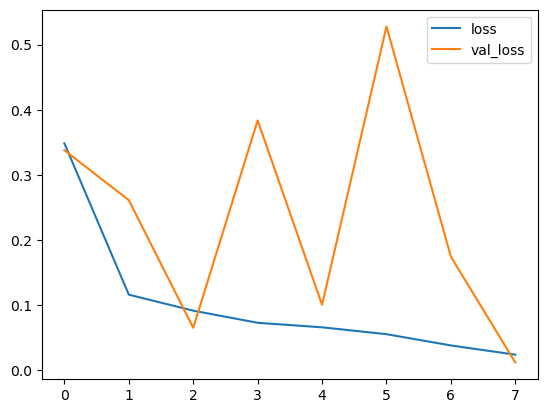

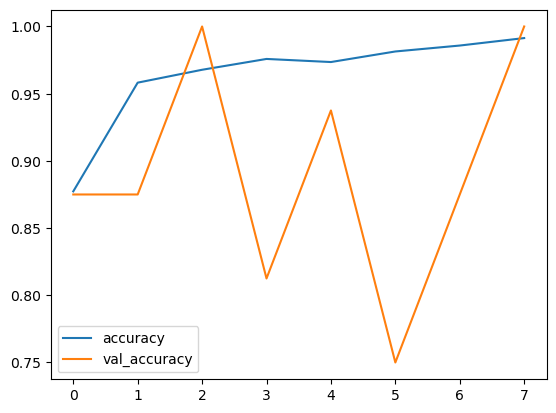

Final training accuracy: 99.13727045059204
Final validation accuracy: 100.0


In [25]:
import pandas as pd

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

# Print final training accuracy
print("Final training accuracy: {}".format(history.history['accuracy'][-1]*100 ))

# Print final validation accuracy
print("Final validation accuracy: {}".format(history.history['val_accuracy'][-1] *100 ))


Our model is performing good on both training dataset and validation dataset. So, this is a good model

**Lets find accuracy on the test dataset**

In [26]:
loss, accuracy = model.evaluate(test_ds)
print('The accuracy of the model on test dataset is',
      np.round(accuracy*100))

20/20 [==============================] - 4s 171ms/step - loss: 2.4020 - accuracy: 0.7484
The accuracy of the model on test dataset is 75.0


### Prediction
Let's predict some random image using our model

1/1 [==============================] - 0s 217ms/step
[0.87726706]
Pneumonia


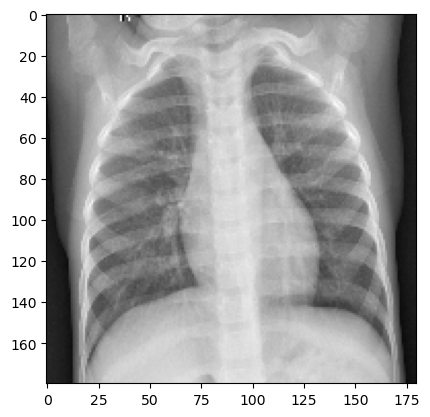

In [ ]:
test_image = tf.keras.utils.load_img(
    './dataset/test/NORMAL/IM-0093-0001.jpeg',
    target_size=(img_height, img_width))

plt.imshow(test_image)
 
test_image = tf.keras.utils.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
 
result = model.predict(test_image)
 
class_probabilities = result[0]
 
# Determine the class with the highest probability and print its label
print(class_probabilities)
if class_probabilities[0] <= 0.5:
    print("Normal")
else:
    print("Pneumonia")

1/1 [==============================] - 0s 28ms/step
[0.8977909]
Pneumonia


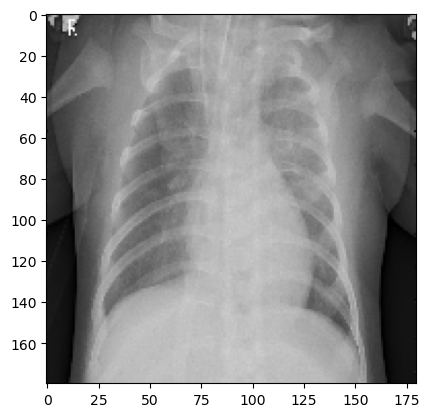

In [ ]:
test_image = tf.keras.utils.load_img(
    './dataset/test/PNEUMONIA/person114_bacteria_544.jpeg',
    target_size=(img_height, img_width))

plt.imshow(test_image)
 
test_image = tf.keras.utils.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
 
result = model.predict(test_image)
 
class_probabilities = result[0]
 
# Determine the class with the highest probability and print its label
print(class_probabilities)
if class_probabilities[0] <= 0.5:
    print("Normal")
else:
    print("Pneumonia")

## Conclusions:
Our model is performing well but as per losses and accuracy curve per iterations. It is overfitting. I tried to use regularization, but it did not work well. This may be due to the unbalanced dataset. By balancing the dataset with an equal number of normal and pneumonia images. We can get a better result.